In [2]:
import numpy as np
import pandas as pd
import skimage

In [3]:
import time

In [4]:
import scanpy as sc

In [5]:
from scipy import  stats

In [71]:
def add_eh_boundary(
    heat_field: np.ndarray,
    field_line: np.ndarray,
    value: float,
) -> None:
    for x, y in field_line:
        heat_field[y, x] = value


def add_gh_boundary(
    heat_field: np.ndarray,
    field_line: np.ndarray,
    value_s: float,
    value_e: float,
) -> None:
    gp_value = np.linspace(value_s, value_e, len(field_line))
    idx = 0
    for x, y in field_line:
        heat_field[y, x] = gp_value[idx]
        idx += 1


def effective_L2_error(
    heat_field_i: np.ndarray,
    heat_field_j: np.ndarray,
    field_mask: np.ndarray,
) -> float:
    return np.sqrt(np.sum((heat_field_j - heat_field_i) ** 2 * field_mask) / np.sum(heat_field_j**2 * field_mask))


def acclerate_matrix(max_err,max_itr,grid_field_raw,field_border,init_field,field_mask):
    err = 1
    itr = 0
    grid_field = grid_field_raw.copy()
    while (err > max_err) and (itr <= max_itr):
        grid_field_pre = grid_field.copy()
        grid_field[1:-1, 1:-1] = 0.25 * (
            grid_field_pre[1:-1, 2:] + grid_field_pre[1:-1, :-2] + grid_field_pre[2:, 1:-1] + grid_field_pre[:-2, 1:-1]
        )
        grid_field = np.where(field_border != 0, init_field, grid_field)
        if itr % 2000 == 0:
            err = effective_L2_error(grid_field, grid_field_pre, field_mask)
        itr = itr + 1
    grid_field[1:-1, 1:-1] = 0.25 * (
            grid_field[1:-1, 2:] + grid_field[1:-1, :-2] + grid_field[2:, 1:-1] + grid_field[:-2, 1:-1]
    )
    return grid_field, itr, err

def domain_heat_eqn_solver(
    field_border: np.ndarray,
    field_mask: np.ndarray,
    max_err: float = 1e-5,
    max_itr: float = 1e5,
    max_border: float = 70
) -> np.ndarray:
    init_field = field_border.copy()
    #layer_mask = field_mask.copy()
    field_mask[field_mask != 0] = 1

    grid_field = np.where(field_border != 0, init_field, field_mask)
    grid_field[grid_field == 1] = max_border


    print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())), f"iteration start")
    grid_field, itr, err = acclerate_matrix(max_err,max_itr,grid_field,field_border,init_field,field_mask)
    if itr >= max_itr:
        print("Max iteration reached, with L2 error at: " + str(err))
    print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())), "Total iteration: " + str(itr))
    grid_field = grid_field * field_mask

    return grid_field

def draw_line(line):
    x = line['x'].tolist()
    y = line['y'].tolist()
    point_array = skimage.draw.line(x[0],y[0],x[1],y[1])
    x_list = [point_array[0]]
    y_list = [point_array[1]]
    for i in range(1,len(x)-1):
        point_array = skimage.draw.line(x[i],y[i],x[i+1],y[i+1])
        x_list = x_list + [point_array[0][1:]]
        y_list = y_list + [point_array[1][1:]]
    x = np.hstack(x_list)
    y = np.hstack(y_list)
    #line_array = np.vstack([x,y]).T
    return x,y

def domain_heat_eqn_solver(
    field_border: np.ndarray,
    field_mask: np.ndarray,
    max_err: float = 1e-5,
    max_itr: float = 1e5,
    max_border: float = 70
) -> np.ndarray:
    init_field = field_border.copy()
    #layer_mask = field_mask.copy()
    field_mask[field_mask != 0] = 1

    grid_field = np.where(field_border != 0, init_field, field_mask)
    grid_field[grid_field == 1] = max_border


    print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())), f"iteration start")
    grid_field, itr, err = acclerate_matrix(max_err,max_itr,grid_field,field_border,init_field,field_mask)
    if itr >= max_itr:
        print("Max iteration reached, with L2 error at: " + str(err))
    print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())), "Total iteration: " + str(itr))
    grid_field = grid_field * field_mask

    return grid_field


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io

In [7]:
from matplotlib.backends.backend_pdf import PdfPages

In [72]:
def dig_pipline(line_path,mask_path):
    line_raw = pd.read_csv(line_path,sep='\t', header=0, compression='infer', comment='#')
    line_raw.columns = ['x', 'y', 'line_id']
    line_raw['line_sid'] = line_raw['line_id'].str.split('+', expand=True)[1]
    line_raw['line_id'] = line_raw['line_id'].str.split('+', expand=True)[0]
    line_raw['x'] = round(line_raw['x'], 0).astype(int)
    line_raw['y'] = round(line_raw['y'], 0).astype(int)

    x_max = line_raw['x'].max()
    y_max = line_raw['y'].max()
    empty_field = np.zeros((y_max+5,x_max+5))
    field_border = empty_field.copy()
    line_id_list = pd.unique(line_raw['line_id'])
    for i in range(0,len(line_id_list)):
        line_l = line_raw[line_raw['line_id'] == line_id_list[i]].copy()
        for j in pd.unique(line_l['line_sid']):
            line_l_tmp = line_l[line_l['line_sid']==j][['x', 'y']].copy()
            line_l_tmp_x,line_l_tmp_y = draw_line(line_l_tmp)
            gp_value = np.linspace(i*1000+1, i*1000+1000, len(line_l_tmp_x))
            field_border[line_l_tmp_y, line_l_tmp_x] = gp_value
    mask = io.imread(mask_path)
    field_mask = np.zeros_like(field_border)
    field_mask[:y_max+5,:x_max+5] = mask[:y_max+5,:x_max+5]
    of_layer = domain_heat_eqn_solver(
        field_border,
        field_mask,
        1e-5,
        1e5,
        0
    )
    return of_layer, line_id_list

In [8]:
mouse_path1 = "/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/mouse_T357.txt"
mouse_path2 = "/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/mouse_T357.tif"
mouse_digmatrix, mouse_line_id_list = dig_pipline(mouse_path1,mouse_path2)

2023-09-29 00:25:21 iteration start
2023-09-29 00:25:26 Total iteration: 2001


In [9]:
#mouse_path1 = "/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/mouse_T354.txt"
#mouse_path2 = "/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/mouse_T354.tif"
marmoset_path1 = "/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/marmoset_T704.txt"
marmoset_path2 = "/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/marmoset_T704.tif"
macaque_path1 = "/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/macaque_T68.txt"
macaque_path2 = "/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/macaque_T68.tif"
mouse_digmatrix, mouse_line_id_list = dig_pipline(mouse_path1,mouse_path2)
marmoset_digmatrix, marmoset_line_id_list = dig_pipline(marmoset_path1,marmoset_path2)
macaque_digmatrix, macaque_line_id_list = dig_pipline(macaque_path1,macaque_path2)

2023-05-04 21:44:27 iteration start
2023-05-04 21:44:31 Total iteration: 2001
2023-05-04 21:44:31 iteration start
2023-05-04 21:44:34 Total iteration: 2001
2023-05-04 21:44:34 iteration start
2023-05-04 21:44:45 Total iteration: 2001


In [9]:
ly,lx = np.where(mouse_digmatrix!=0)
moudf = pd.DataFrame({'coor_x':lx,'coor_y':ly,'columns':mouse_digmatrix[ly,lx]})
moudf.to_csv('/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/mouse.digital_result.2.csv',header=True,sep = '\t')

In [11]:
#ly,lx = np.where(mouse_digmatrix!=0)
#moudf = pd.DataFrame({'coor_x':lx,'coor_y':ly,'columns':mouse_digmatrix[ly,lx]})
#moudf.to_csv('/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/mouse.digital_result.csv',header=True,sep = '\t')
ly,lx = np.where(macaque_digmatrix!=0)
macdf = pd.DataFrame({'coor_x':lx,'coor_y':ly,'columns':macaque_digmatrix[ly,lx]})
macdf.to_csv('/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/macaque.digital_result.csv',header=True,sep = '\t')
ly,lx = np.where(marmoset_digmatrix!=0)
mardf = pd.DataFrame({'coor_x':lx,'coor_y':ly,'columns':marmoset_digmatrix[ly,lx]})
mardf.to_csv('/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/marmoset.digital_result.csv',header=True,sep = '\t')

In [274]:
def pc_gene_line(path,adatad,use_gene,pc_gene):
    df = pd.read_csv(path,sep="\t",header=0)
    obs = adatad.obs.copy()
    gene_index = adatad.var.features.isin(pd.unique(use_gene+pc_gene))
    gene_list = adatad.var[gene_index].features.tolist()
    gene = adatad.raw.X[:, gene_index]
    obs[gene_list] = gene.toarray()
    obs[['coor_x','coor_y']] = obs[['coor_x','coor_y']].astype(int)
    df = pd.merge(df,obs,on=["coor_x","coor_y"])
    df = df.dropna() 

    data_list = []
    df["columns"] = df["columns"].astype(int)
    df_groupby = df.groupby(by=["columns"]).mean().reset_index()

    for i in pd.unique(use_gene+pc_gene):
        idf = df_groupby[["columns",i]].copy()
        idf[i] = idf[i]
        for j in range(0,int(df['columns'].max()/1000+1)):
            line_max = j*1000+1000
            line_min = j*1000+1
            jdf = idf[(idf['columns']>=line_min)&(idf['columns']<line_max)].copy()
            jdf['columns'] = jdf['columns'] - line_min
            kde = stats.gaussian_kde(jdf['columns'].tolist(), bw_method=0.1, weights=jdf[i].tolist())
            x_range = np.linspace(0,1000,1000)
            density = kde(x_range)
            plot = pd.DataFrame({'x':x_range,'y':density,'gene':i,'line':f'line{j+1}'})
            data_list = data_list + [plot]
    all = pd.concat(data_list, axis=0)

    pc_tmp = all[all["gene"].isin(pc_gene)].copy()
    pc_tmp = pc_tmp[["line","x","y"]]
    pc_tmp = pc_tmp.groupby(by=["line","x"]).mean().reset_index()
    aldoc_tmp = all[all["gene"].isin(use_gene)].copy()
    aldoc_tmp = aldoc_tmp[["line","x","y"]]
    aldoc_tmp = aldoc_tmp.groupby(by=["line","x"]).mean().reset_index()
    
    aldoc_tmp['pc'] = pc_tmp['y'].tolist()
    aldoc_tmp['y'] = aldoc_tmp['y'] - aldoc_tmp['pc']
    return aldoc_tmp,all
    #macall = aldoc_tmp

<font size=10>--------Macaque---------</font>

In [ ]:
adata_mac = sc.read_h5ad("/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/T68.h5ad")

In [141]:
macpath = '/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/macaque.digital_result.csv'
macall = pc_gene_line(macpath,adata_mac,'ALDOC',["PCP4","PCP2","CALB1"])

/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/tmp/ipykernel_40228/943210949.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_groupby = df.groupby(by=["columns"]).mean().reset_index()


(-0.0008, 0.0008)

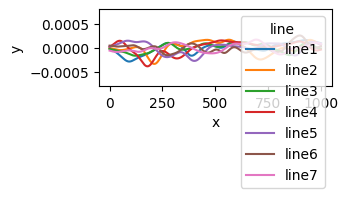

In [143]:
plt.figure(figsize=[3,1])
sns.lineplot(data=macall,x="x",y="y",hue="line")
plt.ylim((-0.0008, 0.0008))

In [144]:
macall.to_csv('/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/paper_plot1018/macaque.density.txt',sep="\t",header=True,index=False)

<font size=10>--------Marmoset---------</font>

In [267]:
adata_mar = sc.read_h5ad("/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/GRID2/line/STh5ad/T704.h5ad")

In [173]:
marpath = '/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/marmoset.digital_result.csv'
marall = pc_gene_line(marpath,adata_mar,['ALDOC'],["PCP4","PCP2","CALB1"])

/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/tmp/ipykernel_40228/2313090240.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_groupby = df.groupby(by=["columns"]).mean().reset_index()


(-0.0008, 0.0008)

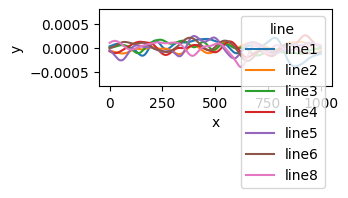

In [174]:
plt.figure(figsize=[3,1])
sns.lineplot(data=marall[marall['line']!='line7'],x="x",y="y",hue="line")
plt.ylim((-0.0008, 0.0008))

In [146]:
marall[marall['line']!='line7'].to_csv('/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/paper_plot1018/marmoset.density.txt',sep="\t",header=True,index=False)

<font size=10>--------Mouse---------</font>

In [124]:
adata_mou = sc.read_h5ad("/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/T357.h5ad")

In [125]:
moupath = '/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/mouse.digital_result.2.csv'
mouall = pc_gene_line(moupath,adata_mou,'Aldoc',["Pcp4","Pcp2","Calb1"])

/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/tmp/ipykernel_40228/2437787097.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_groupby = df.groupby(by=["columns"]).mean().reset_index()


(-0.0008, 0.0008)

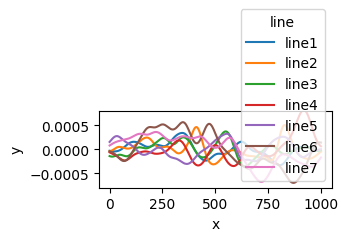

In [126]:
plt.figure(figsize=[3,1])
sns.lineplot(data=mouall,x="x",y="y",hue="line")
plt.ylim((-0.0008, 0.0008))

In [147]:
mouall.to_csv('/jdfssz3/ST_STOMICS/P22Z10200N0661/huangzhi/cerebellum/purkinje_d/ALDOC/paper_plot1018/mouse.density.txt',sep="\t",header=True,index=False)

<font size=10>--------End---------</font>